In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/EVA/session7/New_app

Mounted at /content/drive
/content/drive/My Drive/EVA/session7/New_app


In [2]:
!pwd

/content/drive/My Drive/EVA/session7/New_app


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torch
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
import torch.nn.functional as F
from data_augmentation.albumenatiton import albumentations_transforms

## Model Configuration


In [5]:
# View model config
from config import ModelConfig
args = ModelConfig()
args.print_config()

args

Model Parameters:
{ 'batch_size_cpu': 512,
  'batch_size_cuda': 128,
  'dropout': 0.15,
  'epochs': 50,
  'l1_decay': 3e-06,
  'l2_decay': 0.001,
  'lr': 0.1,
  'max_lr': 0.01,
  'momentum': 0.9,
  'num_workers': 4,
  'seed': 1}


## Data Loading and Visualization


In [6]:
from data_loader.data_pull_CIFAR10_new import data_pull_CIFAR10

In [7]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from GradCAM.gradcam import GradCam
from utils.normalize import normalize,denormalize,imshow
from GradCAM.visualize import VisualizeCam
import matplotlib.pyplot as plt

Files already downloaded and verified
Files already downloaded and verified
  car truck   car  frog


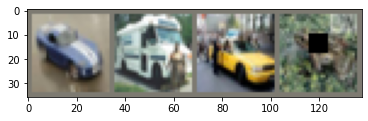

In [8]:
data = data_pull_CIFAR10(args)

# get some random training images
dataiter = iter(data.train_loader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % data.classes[labels[j]] for j in range(4)))

In [11]:
trainloader=data.train_loader
testloader=data.test_loader
classes=data.classes

In [12]:
classes

('plane',
 'car',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck')

## Model Summary

In [13]:
from utils.summary import get_summary
from model.new_cifar10 import NetCifar10

In [14]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model=NetCifar10().to(device)

In [15]:
get_summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
        LayerBlock-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,728
         MaxPool2d-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
              ReLU-8          [-1, 128, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]         147,456
      BatchNorm2d-10          [-1, 128, 16, 16]             256
             ReLU-11          [-1, 128, 16, 16]               0
           Conv2d-12          [-1, 128, 16, 16]         147,456
      BatchNorm2d-13          [-1, 128, 16, 16]             256
             ReLU-14          [-1, 128,

## Learning Rate

In [16]:
from trainer import train_test_fit
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
from learning_rate.lr_finder import LRFinder
from learning_rate.lr_range_test import LRRangeFinder
from learning_rate.lr_zigzag_plot import LRzigzagPlot

  pip install torch-lr-finder -v --global-option="amp"



Learning rate search finished. See the graph with {finder_name}.plot()


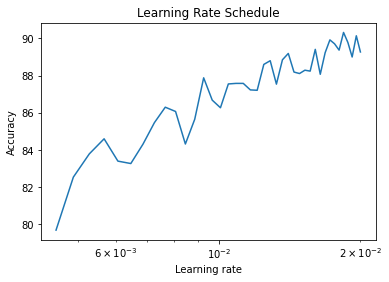

In [22]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
lr_finder = LRRangeFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(trainloader, val_loader=testloader, start_lr=1e-4, end_lr=0.02,
                     epochs=50, step_mode="linear")
lr_finder.plot(metric='acc', skip_start=10, skip_end=0)
lr_finder.reset()

## Best LR

In [23]:
best_acc = lr_finder.best_acc
best_lr = lr_finder.history["lr"][lr_finder.history["acc"].index(best_acc)]
print("Best Accuracy:",best_acc)
print("Best Learning Rate:",best_lr)

Best Accuracy: 90.32
Best Learning Rate: 0.0184090179028133


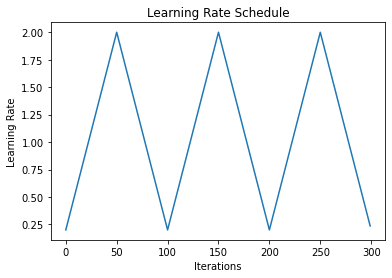

<Figure size 432x288 with 0 Axes>

In [24]:
lrplt = LRzigzagPlot({})
lrplt("lr_LRzigzagPlot_test.png")

## Run the model

In [28]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
scheduler = OneCycleLR(optimizer, max_lr=best_lr, steps_per_epoch=len(trainloader),
                       epochs=args.epochs, div_factor=10, final_div_factor=1,
                       pct_start=5/args.epochs, anneal_strategy="linear")

In [ ]:
train_losses, train_accs, test_losses, test_accs, misclassified_imgs, correct_imgs  =train_test_fit.fit(model, device, trainloader,testloader,classes,criterion,optimizer,scheduler,epochs=24,l1_decay=args.l1_decay, l2_decay=args.l2_decay)

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1 (LR: 0.001682)


L2_loss=276.334 L1_loss=74321.188 Loss=1.59475 Batch_id=97 Accuracy=40.87: 100%|██████████| 98/98 [00:28<00:00,  3.45it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 1.3665, Accuracy: 5202/10000 (52.02%)

EPOCH: 2 (LR: 0.004716)


L2_loss=276.876 L1_loss=74375.422 Loss=1.31831 Batch_id=97 Accuracy=59.95: 100%|██████████| 98/98 [00:28<00:00,  3.46it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 1.1008, Accuracy: 6095/10000 (60.95%)

EPOCH: 3 (LR: 0.007750)


L2_loss=277.508 L1_loss=74454.133 Loss=1.17544 Batch_id=97 Accuracy=69.16: 100%|██████████| 98/98 [00:28<00:00,  3.47it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.7629, Accuracy: 7393/10000 (73.93%)

EPOCH: 4 (LR: 0.010783)


L2_loss=278.129 L1_loss=74531.469 Loss=1.02517 Batch_id=97 Accuracy=74.06: 100%|██████████| 98/98 [00:28<00:00,  3.45it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.8275, Accuracy: 7324/10000 (73.24%)

EPOCH: 5 (LR: 0.013817)


L2_loss=278.773 L1_loss=74620.547 Loss=1.15846 Batch_id=97 Accuracy=76.72: 100%|██████████| 98/98 [00:27<00:00,  3.53it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 1.0388, Accuracy: 7205/10000 (72.05%)

EPOCH: 6 (LR: 0.016812)


L2_loss=279.257 L1_loss=74687.148 Loss=0.73796 Batch_id=97 Accuracy=80.43: 100%|██████████| 98/98 [00:27<00:00,  3.53it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.7607, Accuracy: 7575/10000 (75.75%)

EPOCH: 7 (LR: 0.016015)


L2_loss=279.675 L1_loss=74738.594 Loss=0.84891 Batch_id=97 Accuracy=82.16: 100%|██████████| 98/98 [00:27<00:00,  3.55it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.7152, Accuracy: 7692/10000 (76.92%)

EPOCH: 8 (LR: 0.015218)


L2_loss=280.046 L1_loss=74779.523 Loss=0.82388 Batch_id=97 Accuracy=84.34: 100%|██████████| 98/98 [00:27<00:00,  3.57it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.6179, Accuracy: 8090/10000 (80.90%)

EPOCH: 9 (LR: 0.014422)


L2_loss=280.352 L1_loss=74806.180 Loss=0.70037 Batch_id=97 Accuracy=85.91: 100%|██████████| 98/98 [00:27<00:00,  3.57it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.4613, Accuracy: 8515/10000 (85.15%)

EPOCH: 10 (LR: 0.013625)


L2_loss=280.619 L1_loss=74820.609 Loss=0.66378 Batch_id=97 Accuracy=87.53: 100%|██████████| 98/98 [00:27<00:00,  3.51it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.4627, Accuracy: 8493/10000 (84.93%)

EPOCH: 11 (LR: 0.012828)


L2_loss=280.882 L1_loss=74830.391 Loss=0.69240 Batch_id=97 Accuracy=88.32: 100%|██████████| 98/98 [00:27<00:00,  3.53it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.4517, Accuracy: 8598/10000 (85.98%)

EPOCH: 12 (LR: 0.012031)


L2_loss=281.105 L1_loss=74847.266 Loss=0.53251 Batch_id=97 Accuracy=89.01: 100%|██████████| 98/98 [00:27<00:00,  3.56it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.4553, Accuracy: 8566/10000 (85.66%)

EPOCH: 13 (LR: 0.011235)


L2_loss=281.284 L1_loss=74842.172 Loss=0.60357 Batch_id=97 Accuracy=90.48: 100%|██████████| 98/98 [00:27<00:00,  3.55it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.4510, Accuracy: 8609/10000 (86.09%)

EPOCH: 14 (LR: 0.010438)


L2_loss=281.452 L1_loss=74832.266 Loss=0.55890 Batch_id=97 Accuracy=91.20: 100%|██████████| 98/98 [00:27<00:00,  3.57it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.3876, Accuracy: 8753/10000 (87.53%)

EPOCH: 15 (LR: 0.009641)


L2_loss=281.576 L1_loss=74811.141 Loss=0.55474 Batch_id=97 Accuracy=92.08: 100%|██████████| 98/98 [00:27<00:00,  3.54it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.4520, Accuracy: 8612/10000 (86.12%)

EPOCH: 16 (LR: 0.008845)


L2_loss=281.669 L1_loss=74786.516 Loss=0.55120 Batch_id=97 Accuracy=92.65: 100%|██████████| 98/98 [00:27<00:00,  3.52it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.4100, Accuracy: 8724/10000 (87.24%)

EPOCH: 17 (LR: 0.008048)


L2_loss=281.772 L1_loss=74756.570 Loss=0.52954 Batch_id=97 Accuracy=93.28: 100%|██████████| 98/98 [00:27<00:00,  3.55it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.3855, Accuracy: 8793/10000 (87.93%)

EPOCH: 18 (LR: 0.007251)


L2_loss=281.838 L1_loss=74719.828 Loss=0.50735 Batch_id=97 Accuracy=93.74: 100%|██████████| 98/98 [00:27<00:00,  3.52it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.3646, Accuracy: 8861/10000 (88.61%)

EPOCH: 19 (LR: 0.006454)


L2_loss=281.883 L1_loss=74676.836 Loss=0.44070 Batch_id=97 Accuracy=94.40: 100%|██████████| 98/98 [00:27<00:00,  3.53it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.3614, Accuracy: 8887/10000 (88.87%)

EPOCH: 20 (LR: 0.005658)


L2_loss=281.906 L1_loss=74628.078 Loss=0.47574 Batch_id=97 Accuracy=94.88: 100%|██████████| 98/98 [00:27<00:00,  3.51it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.3669, Accuracy: 8913/10000 (89.13%)

EPOCH: 21 (LR: 0.004861)


L2_loss=281.912 L1_loss=74580.539 Loss=0.48225 Batch_id=97 Accuracy=95.17: 100%|██████████| 98/98 [00:27<00:00,  3.56it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.3417, Accuracy: 8952/10000 (89.52%)

EPOCH: 22 (LR: 0.004064)


L2_loss=281.898 L1_loss=74527.562 Loss=0.41455 Batch_id=97 Accuracy=95.67: 100%|██████████| 98/98 [00:27<00:00,  3.56it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.3650, Accuracy: 8938/10000 (89.38%)

EPOCH: 23 (LR: 0.003267)


L2_loss=281.865 L1_loss=74471.602 Loss=0.44138 Batch_id=97 Accuracy=96.55: 100%|██████████| 98/98 [00:27<00:00,  3.52it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 88 %
Accuracy of   car : 100 %
Accuracy of  bird : 90 %
Accuracy of   cat : 76 %
Accuracy of  deer : 100 %
Accuracy of   dog : 100 %
Accuracy of  frog : 100 %
Accuracy of horse : 100 %
Accuracy of  ship : 90 %
Accuracy of truck : 100 %

Test set: Average loss: 0.3410, Accuracy: 9016/10000 (90.16%)

EPOCH: 24 (LR: 0.002471)


L2_loss=281.825 L1_loss=74420.984 Loss=0.41551 Batch_id=97 Accuracy=96.90: 100%|██████████| 98/98 [00:27<00:00,  3.55it/s]



Accuracy of plane : 100 %
Accuracy of   car : 85 %
Accuracy of  bird : 100 %
Accuracy of   cat : 66 %
Accuracy of  deer : 85 %
Accuracy of   dog : 75 %
Accuracy of  frog : 87 %
Accuracy of horse : 83 %
Accuracy of  ship : 100 %
Accuracy of truck : 75 %

Test set: Average loss: 0.3167, Accuracy: 9062/10000 (90.62%)



## Plot Validation Loss

In [33]:
from GradCAM.gradcam import GradCam
from utils.normalize import *
from GradCAM.visualize import VisualizeCam
from utils.plots import plot_graph,plot_images

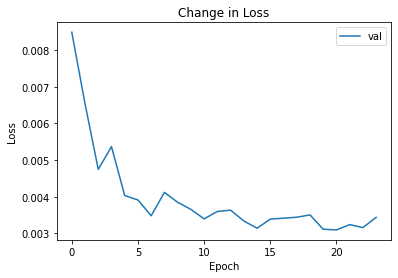

In [34]:
plt_data = {
    "val": test_losses,
}
plot_graph(plt_data, "Loss")

## Plot Validation Accuracy


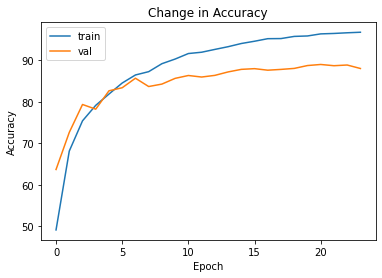

In [35]:
plt_data = {
    "train": train_accs,
    "val": test_accs
}
plot_graph(plt_data, "Accuracy")

## Visualize GradCAM

In [36]:
target_layers = ["layer0", "layer1", "layer2", "layer3"]
viz_cam = VisualizeCam(model,data.classes, target_layers)

### GradCAM for incorrectly classified images

Layer wise visualization of GradCAM for misclassified images

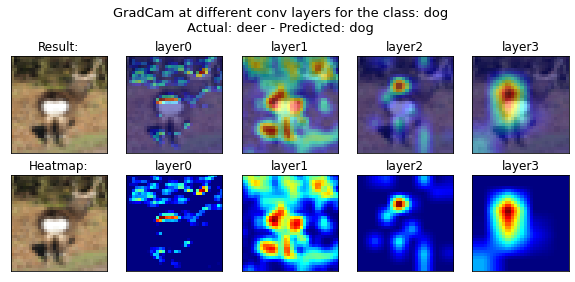

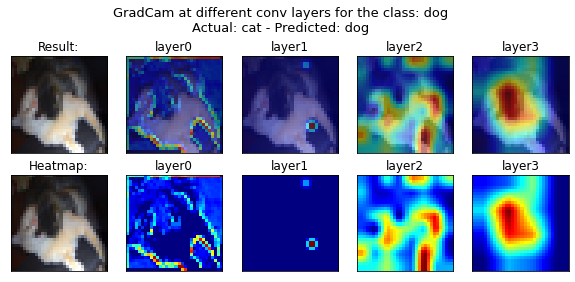

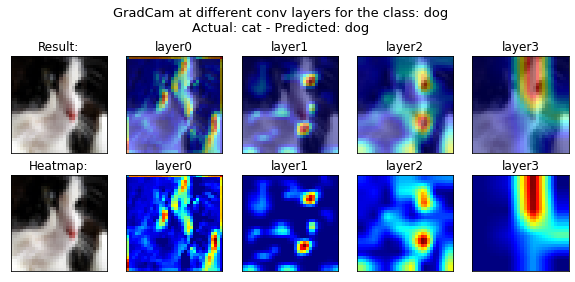

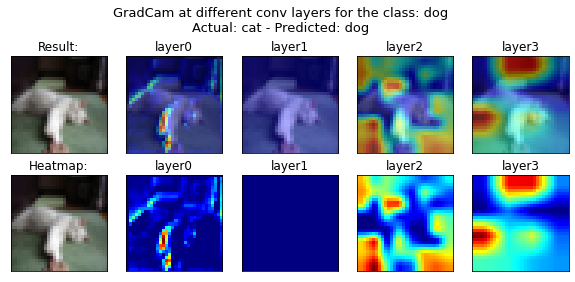

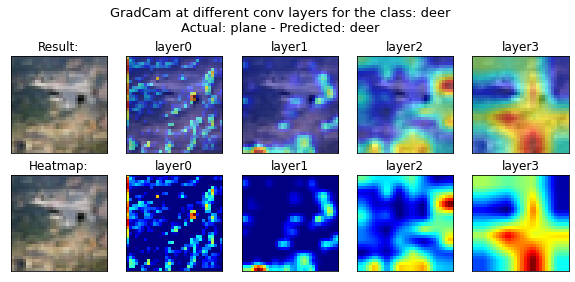

In [37]:
num_img = 5
incorrect_pred_imgs = []
truth_inds = []
for i in range(num_img):
  incorrect_pred_imgs.append(torch.as_tensor(misclassified_imgs[i]["img"]))
  truth_inds.append(misclassified_imgs[i]["target"])
viz_cam(torch.stack(incorrect_pred_imgs), truth_inds, target_layers, metric="incorrect")